/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 812
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 4
[LightGBM] [Info] Start training from score 0.831096
Threads started.  Wait a few seconds…


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

rows = 11   with predictions = 11


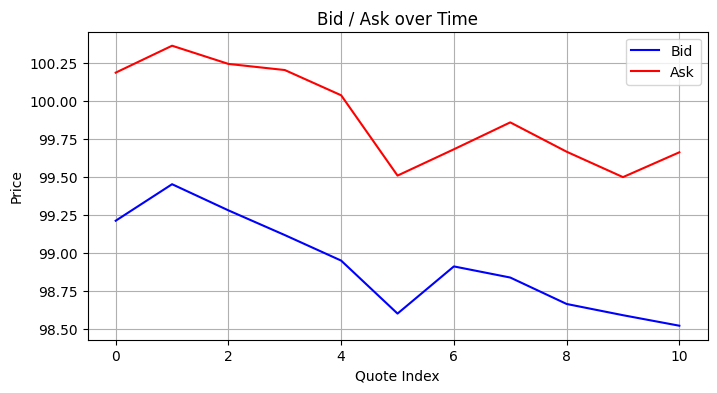

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


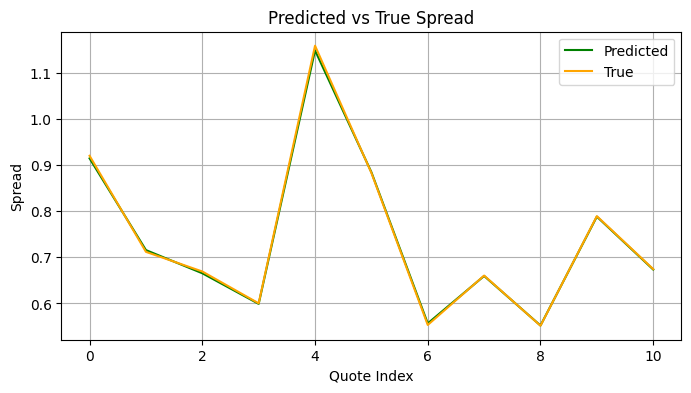

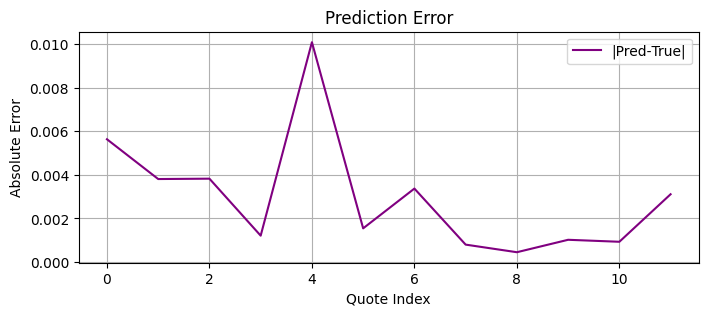

In [1]:
# We first install dependencies
!pip install -q lightgbm

# Let's import dependencies
import numpy as np, pandas as pd, time, threading, queue
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

# Shared state ----------------------------------------------------------------
quotes_df  = pd.DataFrame(columns=['timestamp','bid','ask','vol_bid','vol_ask',
                                   'mid','pred_spread','true_spread'])
quotes_df.index.name = 'id'

db_lock    = threading.Lock()          # guard the DataFrame
data_queue = queue.Queue(maxsize=500)  # Here we simulates a Kafka topic
stop_event = threading.Event()         # graceful shutdown flag

# Synthetic‑feed parameters
BASE_PRICE      = 100.0
PRICE_VOL       = 0.20     # random‑walk σ
BASE_SPREAD     = 1.0
TICK_INTERVAL_S = 0.50

#  TRUE‑SPREAD FORMULA  (ground‑truth for training / scoring)

def true_spread(price_diff: float, vol_bid: int, vol_ask: int) -> float:
    """Toy analytic formula for the 'optimal' quoted spread."""
    return 0.5 + 0.2 * abs(price_diff) + 0.005 * abs(vol_bid - vol_ask)

# SYNTHETIC TRAINING SET  & MODEL FIT

def train_model(n_samples: int = 10_000) -> LGBMRegressor:
    rng = np.random.default_rng(42)
    price_diffs = rng.normal(0, 0.5, n_samples)
    vol_bids    = rng.integers(50, 200, n_samples)
    vol_asks    = rng.integers(50, 200, n_samples)
    vol_diffs   = vol_bids - vol_asks
    y           = [true_spread(d, vb, va)
                   for d, vb, va in zip(price_diffs, vol_bids, vol_asks)]
    X = np.column_stack([price_diffs, vol_bids, vol_asks, vol_diffs])

    model = LGBMRegressor(n_estimators=120, learning_rate=0.1, random_state=1)
    model.fit(X, y)
    return model

model = train_model()      # fit once before threads start

# 4.  THREADS: PRODUCER, CONSUMER, ANALYTICS

def market_data_producer():
    """Generate synthetic quote ticks and publish to queue."""
    rng = np.random.default_rng()
    mid = BASE_PRICE
    tick_id = 0
    while not stop_event.is_set():
        mid += rng.normal(0, PRICE_VOL)
        curr_spread = max(BASE_SPREAD + rng.normal(0, 0.1), 0.1)
        bid, ask = mid - curr_spread/2, mid + curr_spread/2
        vb, va   = rng.integers(50, 200), rng.integers(50, 200)

        msg = dict(id=tick_id, timestamp=time.time(),
                   bid=float(bid), ask=float(ask),
                   vol_bid=int(vb), vol_ask=int(va))
        try:
            data_queue.put_nowait(msg)
        except queue.Full:
            pass   # drop tick on overflow (or log warning)
        tick_id += 1

        # deliberate hiccup every 20 ticks (latency test)
        time.sleep(TICK_INTERVAL_S * (3 if tick_id % 20 == 0 else 1))

def data_consumer():
    """Read queue and append rows to quotes_df."""
    while not stop_event.is_set():
        try:
            msg = data_queue.get(timeout=0.5)
        except queue.Empty:
            continue
        mid = (msg['bid'] + msg['ask']) / 2
        row = [msg['timestamp'], msg['bid'], msg['ask'],
               msg['vol_bid'], msg['vol_ask'], mid, np.nan, np.nan]
        with db_lock:
            quotes_df.loc[msg['id']] = row
        data_queue.task_done()

def analytics_service():
    """Compute features, predict optimal spread, write back."""
    last_mid = None
    next_idx = 0
    while not stop_event.is_set():
        with db_lock:
            if next_idx not in quotes_df.index:
                # no fresh quote yet
                pass
            else:
                quote = quotes_df.loc[next_idx]
                mid   = quote['mid']
                price_diff = 0.0 if last_mid is None else mid - last_mid
                last_mid   = mid

                vb, va   = quote['vol_bid'], quote['vol_ask']
                X        = np.array([[price_diff, vb, va, vb - va]])
                pred_sp  = model.predict(X)[0]
                true_sp  = true_spread(price_diff, vb, va)

                quotes_df.at[next_idx, 'pred_spread'] = float(pred_sp)
                quotes_df.at[next_idx, 'true_spread'] = float(true_sp)
                next_idx += 1
        time.sleep(0.01)

# 5.  PIPELINE CONTROL HELPERS

def start_pipeline():
    """Launch producer / consumer / analytics threads."""
    stop_event.clear()
    global producer_t, consumer_t, analytics_t
    producer_t  = threading.Thread(target=market_data_producer, daemon=True)
    consumer_t  = threading.Thread(target=data_consumer, daemon=True)
    analytics_t = threading.Thread(target=analytics_service, daemon=True)
    producer_t.start(); consumer_t.start(); analytics_t.start()

def stop_pipeline():
    stop_event.set()
    for t in (producer_t, consumer_t, analytics_t):
        t.join(timeout=1)

# 6.  (RE)START  &  INSPECTION CELL

start_pipeline()
print("Threads started.  Wait a few seconds…")
time.sleep(5)      # let it accumulate some ticks

# Quick sanity check
with db_lock:
    print("rows =", len(quotes_df),
          "  with predictions =", quotes_df['pred_spread'].notna().sum())

#  STATIC MATPLOTLIB VISUALS

def plot_prices():
    with db_lock:
        df = quotes_df.dropna(subset=['bid','ask']).copy()
    if df.empty:
        print("No price data yet."); return
    plt.figure(figsize=(8,4))
    plt.plot(df.index, df['bid'], label='Bid', c='blue')
    plt.plot(df.index, df['ask'], label='Ask', c='red')
    plt.xlabel('Quote Index'); plt.ylabel('Price')
    plt.title('Bid / Ask over Time'); plt.legend(); plt.grid(True); plt.show()

def plot_spreads():
    with db_lock:
        df = quotes_df.dropna(subset=['pred_spread','true_spread']).copy()
    if df.empty:
        print("No spread data yet."); return
    plt.figure(figsize=(8,4))
    plt.plot(df.index, df['pred_spread'], label='Predicted', c='green')
    plt.plot(df.index, df['true_spread'], label='True', c='orange')
    plt.xlabel('Quote Index'); plt.ylabel('Spread')
    plt.title('Predicted vs True Spread'); plt.legend(); plt.grid(True); plt.show()

def plot_error():
    with db_lock:
        df = quotes_df.dropna(subset=['pred_spread','true_spread']).copy()
    if df.empty:
        print("No error data yet."); return
    err = (df['pred_spread'] - df['true_spread']).abs()
    plt.figure(figsize=(8,3))
    plt.plot(df.index, err, c='purple', label='|Pred‑True|')
    plt.xlabel('Quote Index'); plt.ylabel('Absolute Error')
    plt.title('Prediction Error'); plt.legend(); plt.grid(True); plt.show()

# Call plotting helpers whenever you want a snapshot:
plot_prices()
plot_spreads()
plot_error()

# Here's a debugging step, I commented it: CLEAN SHUTDOWN (run at the end of your session)

# stop_pipeline()